### Parameter

In [1]:
# WORD-level
MAX_NUM_WORDS     = 15000
EMBEDDING_DIM     = 100
MAX_SEQ_LENGTH    = 500
USE_GLOVE         = True
KERNEL_SIZES      = [3,4,5]
FEATURE_MAPS      = [200,200,200]

# CHAR-level
USE_CHAR          = False
ALPHABET          = "abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
ALPHABET_SIZE     = len(ALPHABET)
CHAR_MAX_LENGTH   = 1600
CHAR_KERNEL_SIZES = [5,10,20]
CHAR_FEATURE_MAPS = [200,200,200]

# GENERAL
DROPOUT_RATE      = 0.4
HIDDEN_UNITS      = 200
NB_CLASSES        = 7

# LEARNING
BATCH_SIZE        = 100
NB_EPOCHS         = 10
RUNS              = 5
VAL_SIZE          = 0.3

### Preprocessing

In [2]:
import pandas as pd

# Read data
df = pd.read_csv("../processed_for_CNN.csv")
df[['roles','msgs']]

roles  \
0      0.0 0.0 0.0 1.0 0.0 0.0 1.0   
1      0.0 0.0 0.0 0.0 1.0 0.0 0.0   
2      1.0 0.0 0.0 0.0 1.0 0.0 0.0   
3      1.0 0.0 0.0 0.0 0.0 0.0 0.0   
4      0.0 0.0 1.0 0.0 0.0 0.0 0.0   
...                            ...   
71180  0.0 1.0 0.0 0.0 0.0 0.0 0.0   
71181  0.0 0.0 0.0 0.0 0.0 0.0 1.0   
71182  0.0 0.0 0.0 0.0 0.0 0.0 1.0   
71183  0.0 0.0 0.0 0.0 0.0 0.0 1.0   
71184  0.0 0.0 0.0 0.0 0.0 0.0 1.0   

                                                    msgs  
0      chinese wall training of one hour have be sche...  
1                                                he trip  
2      attach please find key contact list for energy...  
3      sue landwehr in government affair spoke to mem...  
4      thank you for signing up with ethink you may l...  
...                                                  ...  
71180  here be the sound system proposal reference oa...  
71181                             happy new year mark xl  
71182  feb dec trade feb dec ll go out at do not have...  
71183  bom to trade and feb trade away trade and feb ...  
71184  howdy bom go out at feb trade and mar away and...  

[71185 rows x 2 columns]

In [3]:
labels = list()
for line in df["roles"]:
    label= [int(float(i)) for i in line.split()]
    labels.append(label)
labels[:5]

[[0, 0, 0, 1, 0, 0, 1],
 [0, 0, 0, 0, 1, 0, 0],
 [1, 0, 0, 0, 1, 0, 0],
 [1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0]]

In [4]:
msgs = df["msgs"].to_list()
msgs[:5]

['chinese wall training of one hour have be schedule on the date list below the training be mandatory and allows ew to continue operating all it business include equity trading without violate the security la w please register for one of the four one hour session list below each session be tailor to particular commercial group and it would be preferable if you could attend the session for your group your particula group be the one highlight in bold on the list below monday march resource group monday march origination business development monday march financial trading group monday march head of trading desk each of the above session will be held at the downtown hyatt regency hotel in sandalwood room alternatively two make up session be schedul ed for tuesday march at and location informatio for the make up session will be announce later please confirm your attendance at one of these session with brenda whitehe ad by mail her at brenda whitehead enron com or call her at extension mark 

In [5]:
print(len(msgs))
X = msgs[:5000].copy()
y = labels[:5000].copy()

for i,x in enumerate(X):
    if type(x)!= str:
        X[i] = str(x)
        

71185


### Preprocessing for word-based model

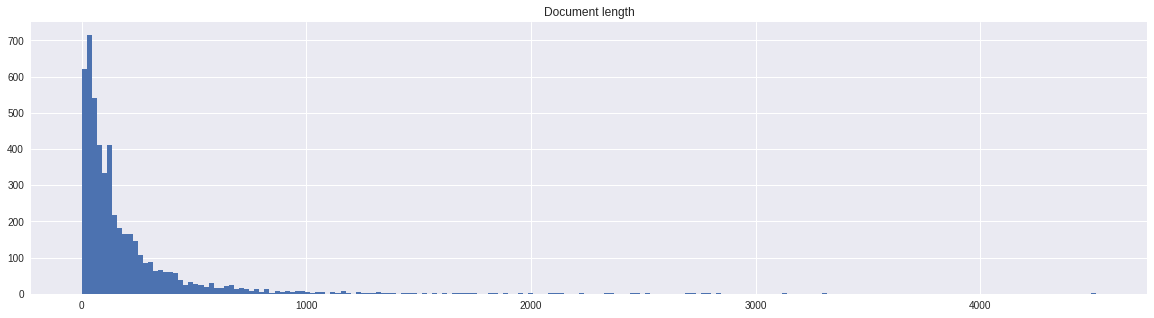

Text informations:
max length: 4517 / min length: 1 / mean length: 190 / limit length: 500


In [6]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

word_index = tokenizer.word_index

result = [len(x.split()) for x in X]

# Plot histogram
plt.figure(figsize=(20,5))
plt.title('Document length')
plt.hist(result, 200, density=False, range=(0,np.max(result)))
plt.show()


print('Text informations:')
print('max length: %i / min length: %i / mean length: %i / limit length: %i' % (np.max(result), np.min(result),
                                                                                np.mean(result), MAX_SEQ_LENGTH))

# Padding all sequences to same length of `MAX_SEQ_LENGTH`
word_data = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQ_LENGTH, padding='post')

### Preprocessing for char-based model

In [7]:
if USE_CHAR:
    char2idx_dict = {}
    idx2char_dict = {}

    for idx, char in enumerate(ALPHABET):
        char2idx_dict[char] = idx + 1

    idx2char_dict = dict([(i+1, char) for i, char in enumerate(char2idx_dict)])
    
    # Get informations about char length
    result = [len(x) for x in X]
    plt.figure(figsize=(20,5))
    plt.title('Char length')
    plt.hist(result, 200, density=False, range=(0,np.max(result)))
    plt.show()
    print('Text informations:')
    print('max: %i / min: %i / mean: %i / limit: %i'%(np.max(result),np.min(result),np.mean(result),CHAR_MAX_LENGTH))

In [8]:
def char_vectorizer(X):
    str2idx = np.zeros((len(X), CHAR_MAX_LENGTH), dtype='int64')
    for idx, doc in enumerate(X):
        max_length = min(len(doc), CHAR_MAX_LENGTH)
        for i in range(0, max_length):
            c = doc[i]
            if c in char2idx_dict:
                str2idx[idx, i] = char2idx_dict[c]
    return str2idx

### Embeddings

In [9]:
def create_glove_embeddings():
    print('Pretrained embedding GloVe is loading...')

    embeddings_index = {}
    with open('../glove.twitter.27B.100d.txt'.format(EMBEDDING_DIM)) as glove_embedding:
        for line in glove_embedding.readlines():
            values = line.split()
            word   = values[0]
            coefs  = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Found %s word vectors in GloVe embedding\n' % len(embeddings_index))

    embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))

    for word, i in tokenizer.word_index.items():
        
        if i >= MAX_NUM_WORDS:
            continue
        
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return tf.keras.layers.Embedding(
        input_dim=MAX_NUM_WORDS,
        output_dim=EMBEDDING_DIM,
        input_length=MAX_SEQ_LENGTH,
        weights=[embedding_matrix],
        trainable=True,
        name="word_embedding"
    )

### Training

In [75]:
from cnn_model import CNN
from sklearn.model_selection import train_test_split

histories = []

for i in range(RUNS):
    print('Running iteration %i/%i' % (i+1, RUNS))
    random_state = np.random.randint(1000)
    
    X_train, X_val, y_train, y_val = train_test_split(word_data, np.array(y),
                                                      test_size=VAL_SIZE, random_state=random_state)
    
    if USE_CHAR:
        X_train_c, X_val_c, _, _ = train_test_split(char_vectorizer(X), y,
                                                    test_size=VAL_SIZE, random_state=random_state)
        X_train = [X_train, X_train_c]
        X_val   = [X_val,   X_val_c]
    
        
    emb_layer = None
    if USE_GLOVE:
        emb_layer = create_glove_embeddings()
    
    model = CNN(
        embedding_layer   = emb_layer,
        num_words         = MAX_NUM_WORDS,
        embedding_dim     = EMBEDDING_DIM,
        kernel_sizes      = KERNEL_SIZES,
        feature_maps      = FEATURE_MAPS,
        max_seq_length    = MAX_SEQ_LENGTH,
        use_char          = USE_CHAR,
        char_max_length   = CHAR_MAX_LENGTH,
        alphabet_size     = ALPHABET_SIZE,
        char_kernel_sizes = CHAR_KERNEL_SIZES,
        char_feature_maps = CHAR_FEATURE_MAPS,
        dropout_rate      = DROPOUT_RATE,
        hidden_units      = HIDDEN_UNITS,
        nb_classes        = NB_CLASSES
    ).build_model()
    
    model.compile(
        loss='MeanSquaredError',  # MeanSquaredError
        optimizer=tf.optimizers.Adam(),
        metrics=['categorical_accuracy']              # categorical_accuracy
    )
    
    history = model.fit(
        X_train, y_train,
        epochs=NB_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(X_val, y_val),
        callbacks=[
            tf.keras.callbacks.ModelCheckpoint(
                'model-%i.h5'%(i+1), monitor='val_loss', verbose=1, save_best_only=True, mode='min'
            ),
        ]
    )

    histories.append(history.history)

Running iteration 1/5
Pretrained embedding GloVe is loading...
Found 1193514 word vectors in GloVe embedding

Epoch 1/10
35/35 [==============================] - ETA: 0s - loss: 0.1104 - categorical_accuracy: 0.5397
Epoch 00001: val_loss improved from inf to 0.10321, saving model to model-1.h5
35/35 [==============================] - 28s 811ms/step - loss: 0.1104 - categorical_accuracy: 0.5397 - val_loss: 0.1032 - val_categorical_accuracy: 0.5580
Epoch 2/10
35/35 [==============================] - ETA: 0s - loss: 0.1078 - categorical_accuracy: 0.5543
Epoch 00002: val_loss improved from 0.10321 to 0.10141, saving model to model-1.h5
35/35 [==============================] - 30s 859ms/step - loss: 0.1078 - categorical_accuracy: 0.5543 - val_loss: 0.1014 - val_categorical_accuracy: 0.5580
Epoch 3/10
35/35 [==============================] - ETA: 0s - loss: 0.1045 - categorical_accuracy: 0.5569
Epoch 00003: val_loss improved from 0.10141 to 0.09779, saving model to model-1.h5
35/35 [========

Epoch 4/10
35/35 [==============================] - ETA: 0s - loss: 0.0975 - categorical_accuracy: 0.5957
Epoch 00004: val_loss improved from 0.09987 to 0.09145, saving model to model-3.h5
35/35 [==============================] - 30s 857ms/step - loss: 0.0975 - categorical_accuracy: 0.5957 - val_loss: 0.0914 - val_categorical_accuracy: 0.6513
Epoch 5/10
35/35 [==============================] - ETA: 0s - loss: 0.0867 - categorical_accuracy: 0.6623
Epoch 00005: val_loss improved from 0.09145 to 0.07953, saving model to model-3.h5
35/35 [==============================] - 30s 853ms/step - loss: 0.0867 - categorical_accuracy: 0.6623 - val_loss: 0.0795 - val_categorical_accuracy: 0.6940
Epoch 6/10
35/35 [==============================] - ETA: 0s - loss: 0.0788 - categorical_accuracy: 0.6911
Epoch 00006: val_loss improved from 0.07953 to 0.07547, saving model to model-3.h5
35/35 [==============================] - 30s 855ms/step - loss: 0.0788 - categorical_accuracy: 0.6911 - val_loss: 0.0755 

### Evaluation

In [77]:
histories

[{'loss': [0.11043373495340347,
   0.10781702399253845,
   0.10451385378837585,
   0.09940700978040695,
   0.08952801674604416,
   0.08001948893070221,
   0.0744919627904892,
   0.07091101258993149,
   0.066095270216465,
   0.0628972053527832],
  'categorical_accuracy': [0.5397142767906189,
   0.5542857050895691,
   0.556857168674469,
   0.5882856845855713,
   0.6462857127189636,
   0.6974285840988159,
   0.7120000123977661,
   0.7262856960296631,
   0.7480000257492065,
   0.7611428499221802],
  'val_loss': [0.10320864617824554,
   0.10141441971063614,
   0.09778855741024017,
   0.08843214809894562,
   0.08018910884857178,
   0.07345909625291824,
   0.06998623162508011,
   0.06889904290437698,
   0.06733401119709015,
   0.06616684794425964],
  'val_categorical_accuracy': [0.5580000281333923,
   0.5580000281333923,
   0.5680000185966492,
   0.6460000276565552,
   0.6733333468437195,
   0.7020000219345093,
   0.7206666469573975,
   0.7133333086967468,
   0.7253333330154419,
   0.73066663

In [78]:
def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)
    
print('Training: \t%0.4f loss / %0.4f acc'   % (get_avg(histories,'loss'), get_avg(histories,'categorical_accuracy')))
print('Validation: \t%0.4f loss / %0.4f acc' % (get_avg(histories,'val_loss'), get_avg(histories,'val_categorical_accuracy')))

Training: 	0.0646 loss / 0.7543 acc
Validation: 	0.0709 loss / 0.7121 acc


In [79]:
def plot_acc_loss(title, histories, key_acc, key_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    # Accuracy
    ax1.set_title('Model accuracy (%s)' % title)
    names = []
    for i, model in enumerate(histories):
        ax1.plot(model[key_acc])
        ax1.set_xlabel('epoch')
        names.append('Model %i' % (i+1))
        ax1.set_ylabel('accuracy')
    ax1.legend(names, loc='lower right')
    
    # Loss
    ax2.set_title('Model loss (%s)' % title)
    for model in histories:
        ax2.plot(model[key_loss])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
    ax2.legend(names, loc='upper right')
    fig.set_size_inches(20, 5)
    plt.show()

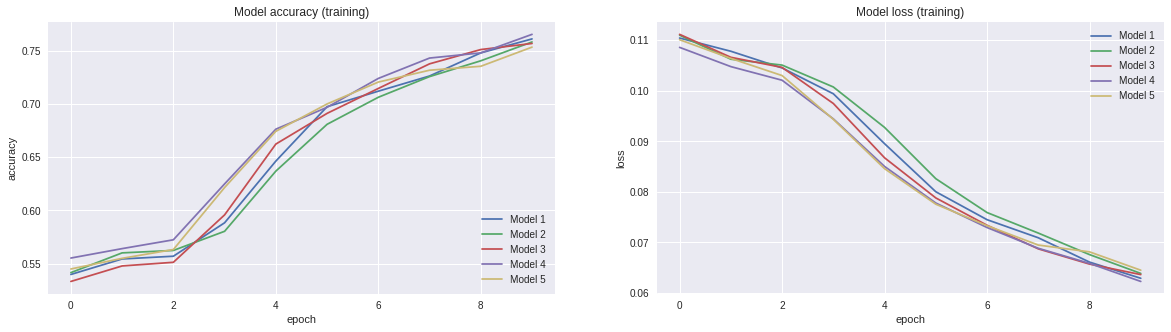

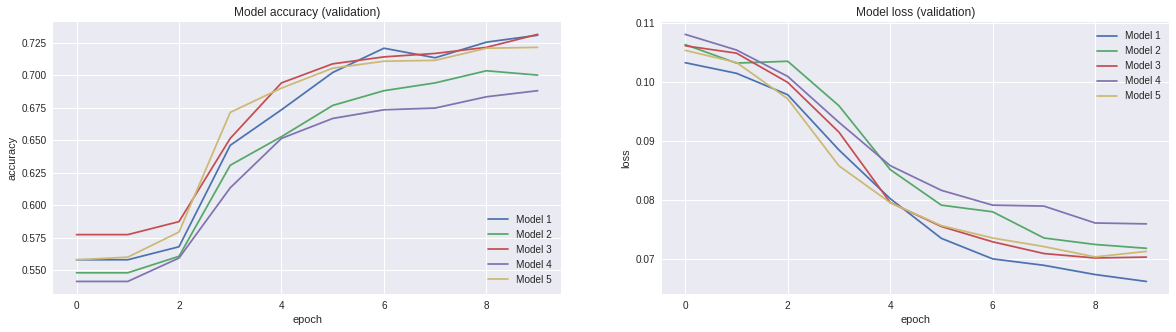

In [80]:
plot_acc_loss('training', histories, 'categorical_accuracy', 'loss')
plot_acc_loss('validation', histories, 'val_categorical_accuracy', 'val_loss')

#### Final test (IMDB / Yelp)

In [10]:
sequences_test = tokenizer.texts_to_sequences(X_test)
X_test_word    = tf.keras.preprocessing.sequence.pad_sequences(sequences_test, maxlen=MAX_SEQ_LENGTH, padding='post')

if USE_CHAR:
    X_test_word = [X_test_word, char_vectorizer(X_test)]
else:
    X_test_word = X_test_word

NameError: name 'X_test' is not defined

In [13]:
import cnn_model

test_loss = []
test_accs = []

for i in range(0,RUNS):
    cnn_ = tf.keras.models.load_model("model-%i.h5" % (i+1))
    score = cnn_.evaluate(X_test_word, tf.keras.utils.to_categorical(y_test), verbose=0)
    test_loss.append(score[0])
    test_accs.append(score[1])
    print('Running test with model %i: %0.4f loss / %0.4f acc' % (i+1, score[0], score[1]))
    
print('\nAverage loss / accuracy on testset: %0.4f loss / %0.4f acc' % (np.mean(test_loss),np.mean(test_accs)))
print('Standard deviation: (+-%0.4f) loss / (+-%0.4f) acc' % (np.std(test_loss), np.std(test_accs)))

Running test with model 1: 0.2480 loss / 0.8984 acc
Running test with model 2: 0.2466 loss / 0.9048 acc
Running test with model 3: 0.2371 loss / 0.9028 acc
Running test with model 4: 0.2526 loss / 0.8981 acc
Running test with model 5: 0.2384 loss / 0.9036 acc

Average loss / accuracy on testset: 0.2445 loss / 0.9016 acc
Standard deviation: (+-0.0059) loss / (+-0.0028) acc


___________________
# Scikit Example

#### Define Vectorizer

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(
    ngram_range  = (1,2),
    min_df       = 0.0005,
    max_df       = 0.1,
    lowercase    = False,
    preprocessor = None,
    sublinear_tf = True, 
    use_idf      = True,
)

#### Define Model

In [12]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(
    max_iter            = 1000, 
    tol                 = 1e-3,
    validation_fraction = 0.2
)

#### Define Pipeline

In [13]:
from sklearn.pipeline import Pipeline

ml_classifier = Pipeline([
    ('vectorizer', tf_idf),
    ('classifier', sgd)
])

#### Train the classifier

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SIZE)
ml_classifier.fit(X_train, y_train)

ValueError: y should be a 1d array, got an array of shape (3500, 7) instead.

In [18]:
val_pred = ml_classifier.predict(X_val)
print('Accuracy:', np.mean(y_val==val_pred))

Accuracy: 0.9078


#### Inspect important features by extracting coefs

Extracted features: 66504


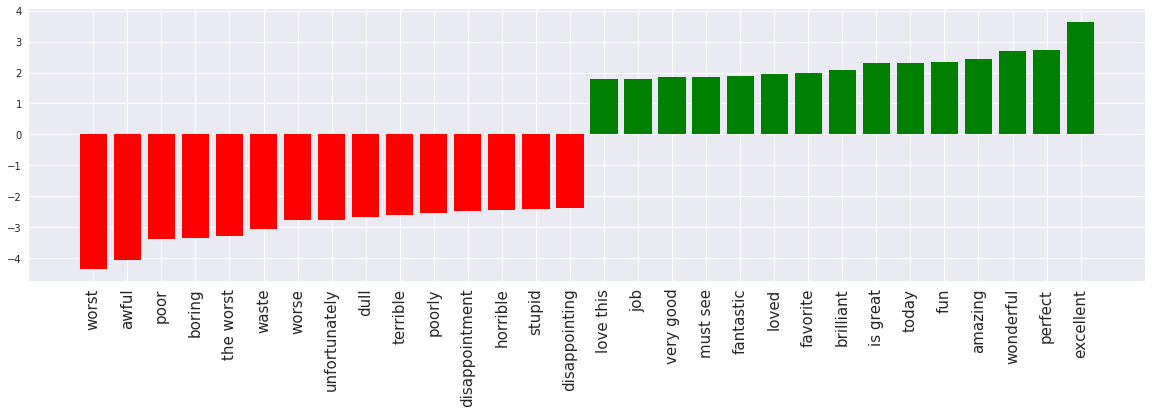

In [19]:
nb_neg_features = 15
nb_pos_features = 15

feature_names = ml_classifier.get_params()['vectorizer'].get_feature_names()
coef = ml_classifier.get_params()['classifier'].coef_.ravel()

print('Extracted features: {}'.format(len(feature_names)))

pos_coef = np.argsort(coef)[-nb_pos_features:]
neg_coef = np.argsort(coef)[:nb_neg_features]
interesting_coefs = np.hstack([neg_coef, pos_coef])

# Plot
plt.figure(figsize=(20, 5))
colors = ['red' if c < 0 else 'green' for c in coef[interesting_coefs]]
plt.bar(np.arange(nb_neg_features + nb_pos_features), coef[interesting_coefs], color=colors)
feature_names = np.array(feature_names)
plt.xticks(np.arange(nb_neg_features+nb_pos_features),feature_names[interesting_coefs],size=15,rotation=90,ha='center');
plt.show()

#### Final evaluation

In [20]:
preds = ml_classifier.predict(X_test)
print('Accuracy:', np.mean(y_test==preds))

Accuracy: 0.90184
